In [1]:
!pip install pyreadr

     |████████████████████████████████| 361 kB 8.6 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir content
!mkdir content/genomics_data
!cp /content/drive/My\ Drive/genomics_data/OCD_Dummy.rds content/genomics_data/OCD_Dummy.rds
!cp /content/drive/My\ Drive/genomics_data/Genetic_Dummy.rds content/genomics_data/Genetic_Dummy.rds
!cp /content/drive/My\ Drive/genomics_data/Batch_Dummy.rds content/genomics_data/Batch_Dummy.rds

In [4]:
import pandas as pd
import numpy as np
import pyreadr
import tqdm

In [5]:
def getData(data):
  return pyreadr.read_r(data)[None]

In [6]:
batch_df = getData("content/genomics_data/Batch_Dummy.rds")
genetic_df = getData("content/genomics_data/Genetic_Dummy.rds")
ocd_df = getData("content/genomics_data/OCD_Dummy.rds")

In [7]:
batch_df.head()

,SampleID,OCD,Experimental,Test,Valid,Train_1,Train_2,Train_3,Train_4,Train_5,...,Train_70,Train_71,Train_72,Train_73,Train_74,Train_75,Train_76,Train_77,ALL,TRAIN
0,ZLJF044767,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,NUZB250104,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,JOOL495893,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,ZKMU498502,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,XYJT184132,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [8]:
genetic_df.head()

,SampleID,rs0728654545,rs9192343147,rs9951538456,rs9692676705,rs6299711483,rs7224000387,rs2486054470,rs2441544862,rs1229871093,...,rs5491526932,rs7331227592,rs4500659624,rs7619812047,rs7224062992,rs5310501663,rs2000209651,rs3199655646,rs9411634933,rs5428412367
0,ZLJF044767,1.000,1.884,2.0,0.0,0.857,1.000,1.000,2.000,0.0,...,0.000,0.000,1.000,0.995,0.000,1.0,2.000,0.016,0.0,2.000
1,NUZB250104,0.957,2.000,1.0,2.0,2.000,1.000,0.998,1.000,0.0,...,1.926,0.999,1.208,1.127,0.000,0.0,0.000,0.000,2.0,0.000
2,JOOL495893,1.000,0.000,2.0,1.0,0.000,0.000,0.037,0.997,1.0,...,0.007,0.000,0.000,1.000,1.875,0.0,0.000,1.000,2.0,1.038
3,ZKMU498502,1.909,1.000,1.0,1.0,0.000,1.000,0.000,0.000,2.0,...,0.000,0.000,0.000,1.000,2.000,1.0,0.002,0.000,0.0,1.996
4,XYJT184132,0.000,1.000,2.0,0.0,0.014,0.421,2.000,0.000,1.0,...,0.000,0.978,0.000,1.000,0.889,0.0,1.069,1.000,0.0,0.577


In [9]:
ocd_df.head()

,SampleID,OCD
0,ZLJF044767,0
1,NUZB250104,0
2,JOOL495893,0
3,ZKMU498502,0
4,XYJT184132,0


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



train_coef = []
train_intercept = []

#---Add this ---- From here-----

cum_model_coef = []
cum_model_intercept = []
cum_res = []

# Test data Creation
sample_ids_valid = list(batch_df.loc[batch_df['Valid']==1]['SampleID'])
genetic_np_valid = genetic_df.loc[genetic_df['SampleID'].isin(sample_ids_valid)].to_numpy()[:,1:]
ocd_np_valid = np.concatenate(ocd_df.loc[ocd_df['SampleID'].isin(sample_ids_valid)].to_numpy()[:,1:])
ocd_np_valid[ocd_np_valid==2]=1


#---Add this ---- To here-----


for i in range(1,78):
  sample_ids = list(batch_df.loc[batch_df['Train_'+str(i)]==1]['SampleID'])
  genetic_np = genetic_df.loc[genetic_df['SampleID'].isin(sample_ids)].to_numpy()[:,1:]
  ocd_np = np.concatenate(ocd_df.loc[ocd_df['SampleID'].isin(sample_ids)].to_numpy()[:,1:])
  ocd_np[ocd_np==2]=1
  ocd_np = ocd_np.astype('int')
  model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.8).fit(genetic_np,ocd_np)
  train_coef.append(model.coef_)
  train_intercept.append(model.intercept_)

  #---Add this ---- From here-----

  train_coef_1 = np.concatenate(train_coef)
  train_intercept_1 = np.concatenate(train_intercept)

  #Finding accuracy on each step
  cum_model_coef = np.mean(train_coef_1, axis=0)
  cum_model_intercept = np.mean(train_intercept_1)

  train_y_prob=[]
  for j in range(len(genetic_np_valid)):
    train_y_prob.append(1/(1+np.exp(-(np.dot(genetic_np_valid[j],cum_model_coef)+cum_model_intercept))))
  train_y_pred=np.array(train_y_prob)
  train_y_pred[train_y_pred>0.5]=1
  train_y_pred[train_y_pred<=0.5]=0
  train_y_pred = train_y_pred.astype('int64')
  ocd_np_valid = ocd_np_valid.astype('int64')
  acc_score = accuracy_score(ocd_np_valid,train_y_pred)
  tn, fp, fn, tp = confusion_matrix(ocd_np_valid,train_y_pred).ravel()
  cum_res.append([acc_score,tn,fp,fn,tp])
  print("model", i," processed")

#print(train_coef)
#print(train_intercept)
print(cum_res)

#---Add this ---- From here-----
# We are doing the testinghere for each kernel, the last row of cum_res contains the model final metrics (acc,fp,fn,tn,tp)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 1  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 2  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 3  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 4  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 5  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 6  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 7  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 8  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 9  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 10  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 11  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 12  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 13  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 14  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 15  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 16  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 17  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 18  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 19  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 20  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 21  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 22  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 23  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 24  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 25  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 26  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 27  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 28  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 29  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 30  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 31  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 32  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 33  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 34  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 35  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 36  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 37  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 38  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 39  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 40  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 41  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 42  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 43  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 44  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 45  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 46  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 47  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 48  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 49  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 50  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 51  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 52  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 53  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 54  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 55  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 56  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 57  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 58  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 59  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 60  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 61  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 62  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 63  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 64  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 65  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 66  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 67  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 68  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 69  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 70  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 71  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 72  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 73  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 74  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 75  processed


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


model 76  processed
model 77  processed
[[0.51, 19, 31, 18, 32], [0.52, 20, 30, 18, 32], [0.49, 17, 33, 18, 32], [0.52, 20, 30, 18, 32], [0.52, 20, 30, 18, 32], [0.58, 20, 30, 12, 38], [0.54, 18, 32, 14, 36], [0.6, 21, 29, 11, 39], [0.53, 19, 31, 16, 34], [0.56, 20, 30, 14, 36], [0.56, 20, 30, 14, 36], [0.58, 23, 27, 15, 35], [0.56, 22, 28, 16, 34], [0.59, 23, 27, 14, 36], [0.61, 24, 26, 13, 37], [0.6, 24, 26, 14, 36], [0.6, 24, 26, 14, 36], [0.59, 24, 26, 15, 35], [0.6, 25, 25, 15, 35], [0.6, 23, 27, 13, 37], [0.61, 24, 26, 13, 37], [0.6, 23, 27, 13, 37], [0.62, 24, 26, 12, 38], [0.61, 23, 27, 12, 38], [0.61, 23, 27, 12, 38], [0.62, 24, 26, 12, 38], [0.62, 24, 26, 12, 38], [0.62, 24, 26, 12, 38], [0.61, 24, 26, 13, 37], [0.61, 24, 26, 13, 37], [0.62, 24, 26, 12, 38], [0.62, 24, 26, 12, 38], [0.61, 23, 27, 12, 38], [0.62, 24, 26, 12, 38], [0.62, 23, 27, 11, 39], [0.62, 23, 27, 11, 39], [0.61, 23, 27, 12, 38], [0.62, 24, 26, 12, 38], [0.62, 24, 26, 12, 38], [0.64, 25, 25, 11, 39], [0.62

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


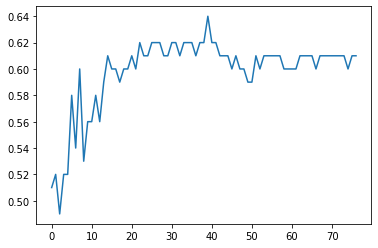

In [17]:
#----Add this cell -----
import matplotlib.pyplot as plt
plt.plot([x[0] for x in cum_res])

AUC:  0.5828


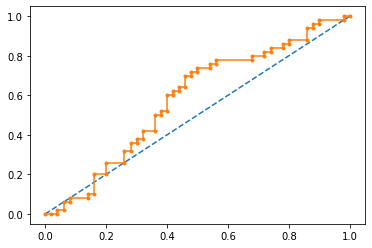

In [25]:
#----Add this cell -----
from sklearn import metrics
# Baseline
baseline = np.array([0 for _ in range(len(train_y_prob))])
# ROC Curve
baseline_fpr,baseline_tpr,_ = metrics.roc_curve(ocd_np_valid,baseline)
predicted_fpr,predicted_tpr,_ = metrics.roc_curve(ocd_np_valid,train_y_prob)

plt.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Baseline')
plt.plot(predicted_fpr, predicted_tpr, marker='.', label='Elastic Net')

#AUC Curve
print("AUC: ", metrics.auc(predicted_fpr,predicted_tpr))


F1 Score:  0.6608695652173914


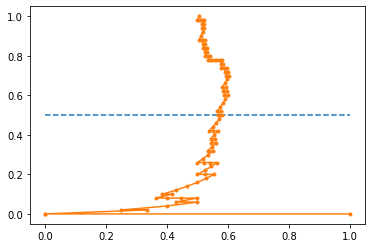

In [27]:
#----Add this cell -----
#Precision Recall Curve
predicted_precision, predicted_recall, _ = metrics.precision_recall_curve(ocd_np_valid, train_y_prob)
baseline_pr=len(ocd_np_valid[ocd_np_valid==1])/len(ocd_np_valid)
plt.plot([0, 1], [baseline_pr, baseline_pr], linestyle='--', label='Baseline')
plt.plot(predicted_precision, predicted_recall, marker='.', label='Elastic Net')

# F1-Score
print("F1 Score: ", metrics.f1_score(ocd_np_valid, train_y_pred))